In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from plotnine import *

定义类获取函数

In [2]:
class DataLoad():
    def __init__(self, csv_path):
        self.csv_path = csv_path
        self.data = pd.read_csv(self.csv_path)
        self.data.sample(frac=1.0, replace=True, random_state=1)
    def getHeader(self):
        return list(self.data.columns.values)
    def getData(self):
        #按照8：2的比例划分为训练集和测试集
        split_train = int(80/100 * len(self.data))
        train = self.data[:split_train]
        test = self.data[split_train:]
        return train, test
    def getFullData(self):
        return self.data

In [3]:
bike=DataLoad('C://Users/litin/Desktop/bike.csv')
bike_full=bike.getFullData()
bike_full.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
category_features = ['season', 'holiday', 'mnth', 'hr', 'weekday', 'workingday', 'weathersit']
number_features = ['temp', 'atemp', 'hum', 'windspeed']
features = category_features + number_features
features

['season',
 'holiday',
 'mnth',
 'hr',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed']

获取数值型指标每列的数据统计信息

In [5]:
bike_full[number_features].describe()

,temp,atemp,hum,windspeed
count,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.496987,0.475775,0.627229,0.190098
std,0.192556,0.171850,0.192930,0.122340
min,0.020000,0.000000,0.000000,0.000000
25%,0.340000,0.333300,0.480000,0.104500
50%,0.500000,0.484800,0.630000,0.194000
75%,0.660000,0.621200,0.780000,0.253700
max,1.000000,1.000000,1.000000,0.850700


缺失值分析：检验数据中的缺失值(无缺失值)

In [6]:
bike_full.isnull().any()

instant       False
dteday        False
season        False
yr            False
mnth          False
hr            False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
casual        False
registered    False
cnt           False
dtype: bool

异常值分析：箱线图

In [7]:
bike_train, bike_test=bike.getData()
bike_train

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13898,13899,2012-08-07,3,1,8,7,0,2,1,2,0.70,0.6667,0.74,0.1343,21,481,502
13899,13900,2012-08-07,3,1,8,8,0,2,1,2,0.70,0.6515,0.70,0.1642,41,664,705
13900,13901,2012-08-07,3,1,8,9,0,2,1,2,0.70,0.6667,0.74,0.1343,44,283,327
13901,13902,2012-08-07,3,1,8,10,0,2,1,2,0.74,0.6970,0.70,0.1343,89,161,250


[Text(0.5, 1.0, 'Box Plot On Count Across Temperature'),
 Text(0, 0.5, 'count'),
 Text(0.5, 0, 'temperature')]

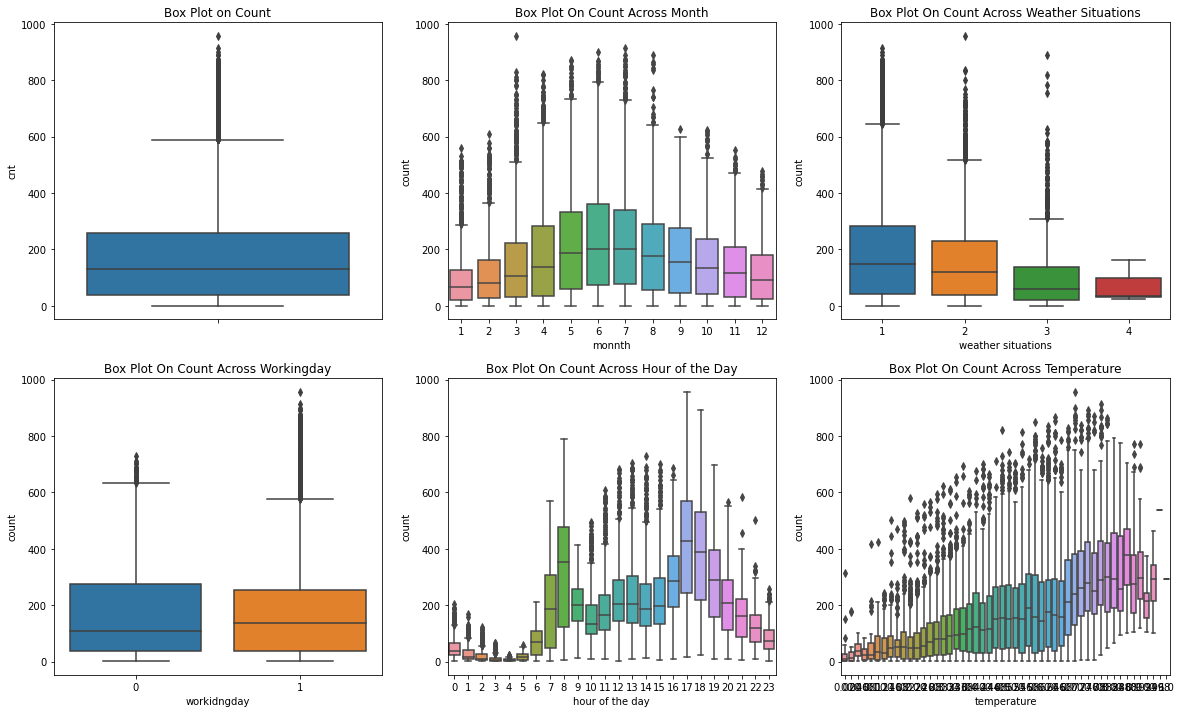

In [8]:
fig,axes=plt.subplots(2,3)
fig.set_size_inches(20,12)#画板设置

sns.boxplot(y="cnt",data=bike_train,orient="v",ax=axes[0,0])
sns.boxplot(y="cnt",x="mnth",data=bike_train,orient="v",ax=axes[0,1])
sns.boxplot(y="cnt",x="weathersit",data=bike_train,orient="v",ax=axes[0,2])
sns.boxplot(y="cnt",x="workingday",data=bike_train,orient="v",ax=axes[1,0])
sns.boxplot(y="cnt",x="hr",data=bike_train,orient="v",ax=axes[1,1])
sns.boxplot(y="cnt",x="temp",data=bike_train,orient="v",ax=axes[1,2])

axes[0,0].set(**{'title':'Box Plot on Count'})
axes[0,1].set(**{'title':'Box Plot On Count Across Month','ylabel':'count','xlabel':'monnth'})
axes[0,2].set(**{'title':'Box Plot On Count Across Weather Situations','ylabel':'count','xlabel':'weather situations'})
axes[1,0].set(**{'title':'Box Plot On Count Across Workingday','ylabel':'count','xlabel':'workidngday'})
axes[1,1].set(**{'title':'Box Plot On Count Across Hour of the Day','ylabel':'count','xlabel':'hour of the day'})
axes[1,2].set(**{'title':'Box Plot On Count Across Temperature','ylabel':'count','xlabel':'temperature'})

工作日的箱型图表明，正常工作日自行车的需求量会高于节假日。小时的箱线图表明，当地早上八点和下午五点需求量最大，这表明共享单车的用户大多数是学生或者上班族。温度的箱线图表明，随着温度上升，共享单车的需求量会有所增加，但异常值也会有所增加。

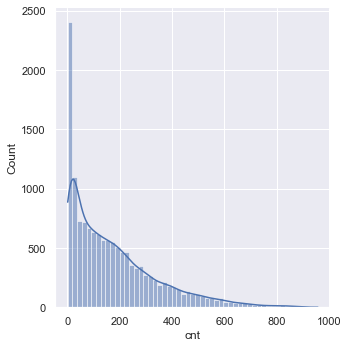

In [9]:
sns.set(color_codes=True)
sns.displot(bike_train['cnt'],kde=True)

cnt的分布图表明，cnt不符合正态分布

没有异常值的训练样本集：12046


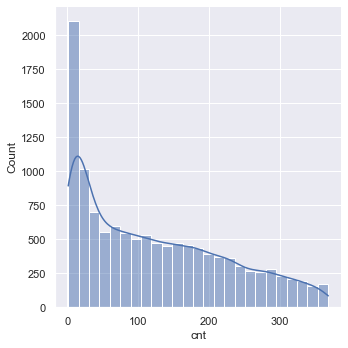

In [10]:
Q1 = bike_train.cnt.quantile(0.25)
Q3 = bike_train.cnt.quantile(0.75)
IQR = Q3 - Q1
low = Q1 - 1.5 * IQR 
up = Q1 + 1.5 * IQR 
bike_train1=bike_train.loc[(bike_train.cnt >= low)&(bike_train.cnt <= up)]
print("没有异常值的训练样本集：{}".format(len(bike_train1)))
sns.displot(bike_train1['cnt'],kde=True)

做对数log处理

In [11]:
bike_train1['cnt'] = bike_train1['cnt'].apply(np.log1p)
bike_train1

C:\Users\litin\AppData\Local\Temp\ipykernel_14608\3892610088.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,2.833213
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,3.713572
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,3.496508
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,2.639057
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13896,13897,2012-08-07,3,1,8,5,0,2,1,1,0.70,0.6667,0.79,0.1045,3,33,3.610918
13897,13898,2012-08-07,3,1,8,6,0,2,1,2,0.70,0.6667,0.79,0.1940,3,176,5.192957
13900,13901,2012-08-07,3,1,8,9,0,2,1,2,0.70,0.6667,0.74,0.1343,44,283,5.793014
13901,13902,2012-08-07,3,1,8,10,0,2,1,2,0.74,0.6970,0.70,0.1343,89,161,5.525453


In [12]:
#bike_train1.to_csv('{}.csv', index=False, sep=',')

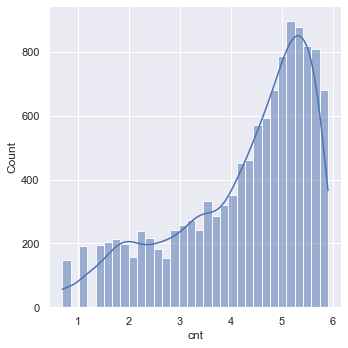

In [13]:
sns.displot(bike_train1['cnt'], kde=True)

相关分析

In [14]:
matrix = bike_train1[number_features + ['cnt']].corr()
matrix

,temp,atemp,hum,windspeed,cnt
temp,1.000000,0.992386,0.014193,-0.054028,0.326468
atemp,0.992386,1.000000,0.027877,-0.095378,0.323167
hum,0.014193,0.027877,1.000000,-0.284533,-0.295621
windspeed,-0.054028,-0.095378,-0.284533,1.000000,0.113807
cnt,0.326468,0.323167,-0.295621,0.113807,1.000000


<AxesSubplot:>

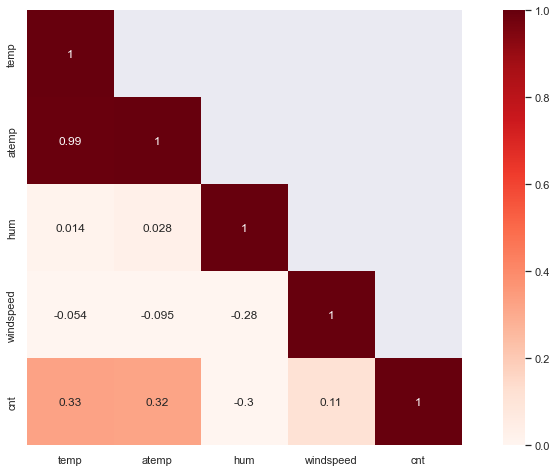

In [15]:
heat = np.array(matrix)
heat[np.tril_indices_from(heat)] = False
fig,ax= plt.subplots()
fig.set_size_inches(15,8)
sns.set(font_scale=1.0)
sns.heatmap(matrix, mask=heat,vmax=1.0, vmin=0.0, square=True,annot=True, cmap="Reds")

变量“temp”和“atemp”是高度相关的
变量“hr”和“temp”似乎是预测自行车共享数量的贡献较大的特征

In [16]:
features.remove('atemp')

In [17]:
bike_test['cnt'] = bike_test['cnt'].apply(np.log1p)

C:\Users\litin\AppData\Local\Temp\ipykernel_14608\3441887885.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
y_train=bike_train1['cnt']
X_train=bike_train1[features]
y_test=bike_test['cnt']
X_test=bike_test[features]

In [19]:
y_test

13903    5.648974
13904    5.537334
13905    5.568345
13906    5.726848
13907    6.100319
           ...   
17374    4.787492
17375    4.499810
17376    4.510860
17377    4.127134
17378    3.912023
Name: cnt, Length: 3476, dtype: float64

评价指标：
MSE 是预测误差的平方的平均值， MSE的值越小说明模型效果越好;
RMSLE 均方根对数误差，适用于某些需要欠预测损失更大的场景

In [20]:
def RMSLE(y,y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v+1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v+1) for v in y_]))
    calc = (log1-log2)**2
    return np.sqrt(np.mean(calc))

线性回归模型

In [21]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [22]:
reg.coef_

array([ 0.06915007, -0.13270041, -0.00186941,  0.09400235,  0.01735828,
       -0.07302808,  0.01602965,  1.86336169, -1.28234062,  0.18130483])

In [23]:
predictions=reg.predict(X_train)
print("RMSE For Linear Regression:", np.sqrt(mean_squared_error(y_train,predictions)))
try:
    RMSLE(y_train, predictions,False)
except Exception:
    print("RMSLE函数定义异常")
print("RMSLE For Linear Regression:", RMSLE(y_train, predictions,False))

RMSE For Linear Regression: 0.9969134822410196
RMSLE For Linear Regression: 0.240165251907104


In [24]:
print('accuracy on traindata:', reg.score(X_train, y_train))
print('accuracy on testdata:', reg.score(X_test, y_test))

accuracy on traindata: 0.4393029641192657
accuracy on testdata: 0.3299729413232857


岭回归

In [25]:
reg.score(X_train, y_train)
reg.score(X_test, y_test)

0.3299729413232857

{'alpha': 30, 'max_iter': 4000}
RMSE For Ridge Regression: 0.9969134822410196
RMSLE Value For Ridge Regression:  0.24050708370848503


<AxesSubplot:xlabel='alpha', ylabel='RMSLE'>

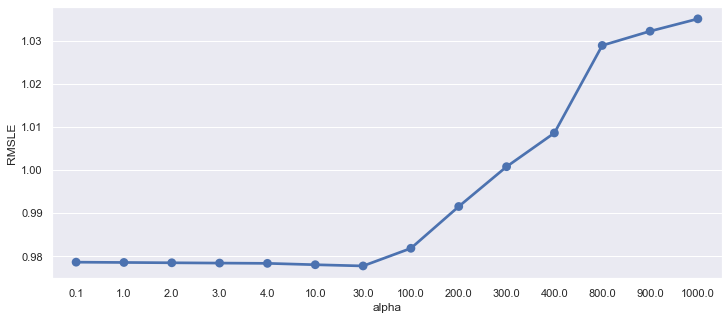

In [26]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[4000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}

scorer = metrics.make_scorer(RMSLE, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_, ridge_params_, scoring = scorer, cv=5)
grid_ridge_m.fit( X_train, y_train )
preds = grid_ridge_m.predict(X= X_train)
print (grid_ridge_m.best_params_)
print("RMSE For Ridge Regression:", np.sqrt(mean_squared_error(y_train,predictions)))
print ("RMSLE Value For Ridge Regression: ",RMSLE(y_train,preds,False))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_ridge_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["RMSLE"] = df["mean_test_score"].apply(lambda x:-x)
sns.pointplot(data=df,x="alpha",y="RMSLE",ax=ax)

随机森林

In [27]:
from sklearn.ensemble import RandomForestRegressor
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Model", "Dataset", "MSE", 'RMSLE']
# 模型训练
model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
model.fit(X_train, y_train) 

def evaluate(x, y, dataset):
    pred = model.predict(x)
    mse = mean_squared_error(y, pred)
    rmsle = RMSLE(y, pred)
    table.add_row([type(model).__name__, dataset,
                  format(mse, '.2f'),
                  format(rmsle, '.2f')])
    
evaluate(X_train, y_train, 'training')
evaluate(X_test, y_test, 'testing')

print(table)

d:\Program Files\anaconda\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.


+-----------------------+----------+------+-------+
|         Model         | Dataset  | MSE  | RMSLE |
+-----------------------+----------+------+-------+
| RandomForestRegressor | training | 0.02 |  0.13 |
| RandomForestRegressor | testing  | 0.32 |  0.56 |
+-----------------------+----------+------+-------+
